# Differences over time

- Created by Jacob Eisenstein, May 2019
- Modified by Sandeep Soni and Ian Stewart, June 2019

Both academics and casual observers believe that politics in the USA has become more polarized. Can we see evidence of this in the language of American legislators? 

This notebooks builds on ideas from Monroe, Colaresi, and Quinn (MCQ) and [data from Gentzkow et al](https://data.stanford.edu/congress_text) to measure partisanship of individual words and track aggregate partisanship over time.
$
\newcommand{\yi}{y^{(i)}}
\newcommand{\yj}{y^{(j)}}
\newcommand{\ai}{\alpha^{(i)}}
\newcommand{\aj}{\alpha^{(j)}}
\newcommand{\ni}{n^{(i)}}
\newcommand{\nj}{n^{(j)}}
\newcommand{\oi}{o^{(i)}}
\newcommand{\oj}{o^{(j)}}
\newcommand{\fi}{f^{(i)}}
\newcommand{\fj}{f^{(j)}}
$

Overview:

- [**Explore text preprocessing**](#text-preprocessing)
- [**Implement and test a metric for political polarization**](#polarization-metric)
- [**Replicate findings from prior work**](#replicate-figure)
- [**Investigate per-word polarization**](#per-word-polarization)
- [**Investigate aggregate polarization**](#aggregate-polarization)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from datetime import datetime

import numpy as np
import sklearn
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import PorterStemmer
from scipy.stats import spearmanr, mode

from tqdm import tqdm_notebook as tqdm

import os
from glob import glob
import pickle

## CSS style for matplotlib images
from IPython.core.display import HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

basedir = os.path.join('..','data','same-diff-processed')

timeseries_figsize=[10,2]

In [2]:
 # set to true if you want to recompute everything from scratch, and have access to the raw data
recomputing_all_data_files = False

## Data acquisition

In this project, we'll use data about U.S. Congressional floor speeches from Gentzkow et al. It's kind of big, so we'll start with data from a single session.

1. If you haven't already done so, get the raw data from the [bitbucket](https://bitbucket.org/jacobeisenstein/language-change-tutorial-data/src/master/), e.g., by running
```
git clone https://bitbucket.org/jacobeisenstein/language-change-tutorial-data.git
```
2. Uncompress the data for this notebook
```
cd language-change-tutorial-data
tar xvzf same-diff-data.tgz
```
3. Move (or link) the folder into `data`, or redefine `basedir` above.
```
cd ../data
ln -s ../language-change-tutorial-data/same-diff-processed
```

In [3]:
#load in the data for the 114th congress (2015-2017)
df_description = pd.read_csv(os.path.join(basedir,'descr_114.txt'),delimiter='|')
df_speeches = pd.read_csv(os.path.join(basedir,'speeches_114.txt'),delimiter='|',
                          error_bad_lines=False,encoding='iso8859')
df_speakers = pd.read_csv(os.path.join(basedir,'114_SpeakerMap.txt'),delimiter='|')

b'Skipping line 81799: expected 2 fields, saw 3\n'


First let's identify all speeches by members of each political party. We'll do this by joining the speeches and party information.

In [4]:
df_speeches.head(3)

,speech_id,speech
0,1140000001,The Representativeselect and their guests will...
1,1140000002,As directed by law. the Clerk of the House has...
2,1140000003,Four hundred and one Represent ativeselect hav...


In [5]:
df_speech_by_party = pd.merge(df_speeches, df_speakers, on='speech_id')[['speech_id','speech','party']]

In [6]:
print(df_speech_by_party.shape)
df_speech_by_party.head(3)

(67970, 3)


,speech_id,speech,party
0,1140000007,RODGERS. Madam Clerk. it is an honor to addres...,R
1,1140000009,Madam Clerk. first I would like to recognize e...,D
2,1140000011,Madam Clerk. I present for election to the off...,R


Many of these utterances are legislative formalities, so let's focus on speeches that are at least 1000 characters long.

In [7]:
df_speech_by_party = df_speech_by_party.loc[df_speech_by_party['speech'].apply(lambda x : len(x) > 1000)]

In [8]:
print(df_speech_by_party.shape)
df_speech_by_party.head(3)

(25832, 3)


,speech_id,speech,party
0,1140000007,RODGERS. Madam Clerk. it is an honor to addres...,R
1,1140000009,Madam Clerk. first I would like to recognize e...,D
3,1140000013,Madam Clerk. I present for the election of the...,R


Now let's merge in the date information to create the final dataframe.

In [9]:
df = pd.merge(df_speech_by_party, df_description, on='speech_id')[['speech_id','speech','party','date']]

In [10]:
df.head(3)

,speech_id,speech,party,date
0,1140000007,RODGERS. Madam Clerk. it is an honor to addres...,R,20150106
1,1140000009,Madam Clerk. first I would like to recognize e...,D,20150106
2,1140000013,Madam Clerk. I present for the election of the...,R,20150106


### Preprocessing

For temporal analysis, we need to convert the date field from an integer to a datetime object. We'll do that using the python `datetime` package.

In [11]:
df['date'] = df['date'].astype('str')
df['date'] = df['date'].apply(lambda x : datetime(year=int(x[:4]),
                                     month=int(x[4:6]),
                                     day=int(x[6:])))

In [12]:
df['date'].head(3)

0   2015-01-06
1   2015-01-06
2   2015-01-06
Name: date, dtype: datetime64[ns]

Next, we need to convert the "speech" field into something that will be easier to handle. For now, we'll use a simple **bag-of-words** representation. The `scikit-learn` library provides a useful class `CountVectorizer` for handling this preprocessing.

In [13]:
MAX_FEATURES = 10000
vect = CountVectorizer(max_features=MAX_FEATURES)

In [14]:
## this will take a minute to run
SPEECH_COUNT = 2500
speech_mat = vect.fit_transform(df['speech'][:SPEECH_COUNT])

In [15]:
speech_mat

<2500x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 590690 stored elements in Compressed Sparse Row format>

The result is a sparse matrix, specifically a member of `scipy.sparse.csr_matrix`. The columns of this matrix are identified by the vectorizer's vocabulary:

In [16]:
{i:j for i,j in list(vect.vocabulary_.items())[:6]}

{'madam': 5570,
 'clerk': 1789,
 'it': 5002,
 'is': 4976,
 'an': 694,
 'honor': 4462}

In [17]:
# lookup
ivoc = {idx:word for word,idx in vect.vocabulary_.items()}

The `CountVectorizer` can be used to do more sophisticated text pre-processing in a very general manner. We have written a parameterized wrapper which will return a vectorizer, the sparse matrix and the vocabulary mapping when given raw text. The parameters to this function controls the composition of the vocabulary. For example, the size or the type of words. We'll see how this affects the analysis later.

In [18]:
def text2matrix (text, max_features=10000, min_df=1, max_df=1.0, stop_words=None, stemming=False, lowercase=False):
    """
    Convert raw text data to document-term matrix.
    
    Parameters:
    -----------
    text : string
        Raw text to convert.
    max_features : int
        Max number of words to include in vocabulary.
    min_df : int or float
        Min number or proportion of documents in which a word must occur to be included in vocabulary.
    max_df : int or float
        Max number or proportion of documents in which a word must occur to be included in vocabulary.
    stop_words : bool
        Whether to exclude stop words ("the", "of", etc.) from vocabulary.
    stemming : bool
        Whether to stem words ("regulate" becomes "regul").
    lowercase : bool
        Whether to convert words to lowercase.
    
    Returns:
    --------
    vectorizer : CountVectorizer
        Trained CountVectorizer with vocabulary data.
    mat : scipy.sparse.csr_matrix
        Sparse count matrix.
    ivoc : dict
        Inverse dictionary to map matrix column to vocabulary string.
    """
    if stemming:
        # default tokenizer to split words
        token_pattern = r"(?u)\b\w\w+\b"
        token_matcher = re.compile(token_pattern)
        tokenizer = lambda doc: token_matcher.findall(doc)
        # stemmer
        stemmer = PorterStemmer()
        do_analysis = lambda doc: (stemmer.stem(w) for w in tokenizer(doc))
    else:
        do_analysis = "word"
    # build vectorizer
    vectorizer = CountVectorizer (max_features=max_features, min_df=min_df, max_df=max_df, stop_words=stop_words, lowercase=lowercase, analyzer=do_analysis)
    mat = vectorizer.fit_transform(text)
    ivoc = {idx:word for word,idx in vectorizer.vocabulary_.items()}
    return vectorizer, mat, ivoc

Later we'll modify some of the text preprocessing parameters to determine how they impact the results (ex. preserving case).

In [19]:
vect, speech_mat, ivoc = text2matrix (df['speech'][:SPEECH_COUNT], max_features=MAX_FEATURES, lowercase=True, stemming=False)

For simplicity in analysis, we will create a dataframe where each row has the count of a word per party per day.

In [21]:
def text_to_aggregate(frame, vect, parties=["R", "D"]):
    """
    Convert speech data to an easier format to work 
    with: word | R_count | D_count | date
    """
    grouped = frame.groupby(by=["date"]) 
    agg_df = []
    # convert speeches to text matrix
    speech_mat = vect.transform (frame.loc[:, "speech"])
    # collect all unique dates
    unique_dates = sorted(frame.loc[:, "date"].unique())
    # sort vocab into same order as matrix columns
    sorted_vocab = [v[0] for v in sorted (vect.vocabulary_.items(), key=lambda x:x[1])]
    sorted_vocab_count = len(sorted_vocab)
    frame_parties = frame.loc[:, "party"]
    frame_dates = frame.loc[:, "date"]
    # make empty array for data:
    # R_count | D_count | word | date
    agg_df_rows = len(sorted_vocab) * len(unique_dates)
    agg_df_cols = 2 + len(parties)
    agg_df = np.zeros((agg_df_rows, agg_df_cols)).astype(object)
    for party_ctr, party in enumerate(parties):
        for date_ctr, date in enumerate(unique_dates):
            # find docs that match party and date
            party_date_indices = (frame_parties == party) & (frame_dates == date)
            party_date_indices = party_date_indices[party_date_indices].index
            # compute party counts
            if(len(party_date_indices) > 0):
                # sum over all indices
                party_date_counts = speech_mat[party_date_indices, ].sum(axis=0)
                # flatten counts
                party_date_counts = np.array(party_date_counts)[0]
            else:
                party_date_counts = np.zeros(sorted_vocab_count)
            # add party date counts to matrix
            # using the matching column and rows (one count per row)
            agg_df_row_indices = range((date_ctr*sorted_vocab_count), ((date_ctr+1)*sorted_vocab_count))
            agg_df[agg_df_row_indices, party_ctr] = party_date_counts
    # add words and dates to array
    # add words
    vocab_repeated = np.hstack(np.repeat(np.array(sorted_vocab).reshape(1, sorted_vocab_count), len(unique_dates), axis=0))
    agg_df[:, len(parties)] = vocab_repeated
    # add dates
    dates_repeated = np.repeat(unique_dates, sorted_vocab_count)
    agg_df[:, len(parties)+1] = dates_repeated
    # convert to data frame
    party_cols = ['%s_count'%(party.lower()) for party in parties]
    agg_df_cols = party_cols + ['word', 'date']
    agg_df = pd.DataFrame(agg_df, columns=agg_df_cols)
    # fix data types
    # change date to timestamp
    agg_df = agg_df.assign(**{'date' : agg_df.loc[:, 'date'].apply(pd.Timestamp)})
    # change counts to ints
    for party_col in party_cols:
        agg_df = agg_df.assign(**{party_col : agg_df.loc[:, party_col].astype(int)})
    return agg_df

In [22]:
#just run once
aggregate_df = text_to_aggregate(df[:SPEECH_COUNT], vect)

In [23]:
# sanity check
display(aggregate_df.head())

,r_count,d_count,word,date
0,7,4,000,2015-01-06
1,0,0,000plus,2015-01-06
2,2,12,10,2015-01-06
3,1,2,100,2015-01-06
4,0,0,1000,2015-01-06


Let's check the number of unique dates and words.

In [24]:
T = len(aggregate_df['date'].unique())
V = len(aggregate_df['word'].unique())
print (T)
print (V)

29
10000


## Baselines

We'll start by computing partisanship of individual terms across all sessions. Once we have an effective method, we'll move to the dynamic analysis. 

A simple baseline is to compare the **log odds ratios**:

$\begin{align}
\oi_{w} = &{} \frac{\fi_w}{1 - \fi_w}\\
r_w = &{} \log \oi_w - \log \oj_w,
\end{align}$

where $\fi_w$ is the frequency of word $w$ in group $i$.

In [25]:
# let's get the most recent monthly counts as a numpy array and the log odds ratio from the counts
def get_log_odds_ratio (agg_df, V, eps=1e-5, verbose=True):
    counts = agg_df.loc[agg_df['date']==agg_df['date'].unique().max()][['d_count','r_count']].to_numpy().T
    if(verbose): 
        print('counts:\n',counts)

    # zero counts arise because the vocabulary includes words that were introduced at other times
    # to account for that we do some smoothing
    f = ((counts + eps).T / (V*eps + counts.sum(1))).T
    log_odds_ratio = np.log(f[0,]/(1-f[0,])) - np.log(f[1,]/(1-f[1,]))
    if(verbose):
        print('log-odds ratio:\n',log_odds_ratio)
        
    return counts, log_odds_ratio

counts, log_odds_ratio = get_log_odds_ratio (aggregate_df, V)

counts:
 [[12  0  5 ...  2  0  0]
 [ 8  0  1 ...  0  2  0]]
log-odds ratio:
 [ -0.15321494  -0.55856744   1.05104613 ...  11.64762315 -12.76484254
  -0.55856744]


In [26]:
print (mode(log_odds_ratio), log_odds_ratio.shape)

ModeResult(mode=array([-0.55856744]), count=array([6556])) (10000,)


As expected, the modal log odds ratio is near $0$, corresponding to the case in which a word is equally likely in both groups.

Now let's look at the top words for each group by this metric.

In [27]:
def print_most_associated_words (ratios, lookup, topk=10, party="R"):
    MAX_LEN = 20
    scalar = 1
    if party == "D":
        scalar = -1
    
    indices = (scalar * ratios).argsort ()[:topk]
    
    print ("========")
    print ("{} words".format (party))
    print ("========")
    
    for index in indices:
        print ("{0}{1}{2:.2f}".format (lookup[index], " " * (MAX_LEN - len (lookup[index])), ratios[index]))
    print()
    

In [28]:
print_most_associated_words (log_odds_ratio, ivoc, party="R")
print_most_associated_words (log_odds_ratio, ivoc, party="D")

R words
gas                 -14.38
helen               -14.15
kilroy              -14.15
west                -14.15
congregation        -14.02
debt                -14.02
innovation          -14.02
boards              -14.02
mosaic              -13.86
honor               -13.86

D words
dhs                 14.17
fund                13.90
snap                13.79
shutdown            13.73
poverty             13.66
resources           13.66
risk                13.52
lowincome           13.44
jersey              13.44
shut                13.44



While some of these terms make sense, many are quite rare. Indeed, rare words tend to dominate the unsmoothed log odds ratio. 

This can be shown by a clever figure design by Monroe, Colaresi, and Quinn (MCQ 2009), whose paper is discussed below.

In [29]:
def make_word_importance_figure(scores, counts, ivoc, num_keywords = 20):
    fig = plt.figure(figsize=[12,6])
    ax = plt.gca()
    ax.plot(counts.sum(0), scores, '.', alpha=0.2, markeredgecolor='none', color='k')
    ax.set_xscale('log')
    plt.xlabel('count')
    plt.ylabel('score');
    for word_idx in scores.argsort()[:num_keywords]:
        plt.text(counts.sum(0)[word_idx], scores[word_idx], ivoc[word_idx], color='r')
    for word_idx in scores.argsort()[::-1][:num_keywords]:
        plt.text(counts.sum(0)[word_idx], scores[word_idx], ivoc[word_idx], color='b')
    
    # ranked order on the side
    all_words = [ivoc[idx] for idx in list(scores.argsort()[:num_keywords])]\
    + [' ']\
    + [ivoc[idx] for idx in list(scores.argsort()[::-1][:num_keywords][::-1])]

    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    _,_, x_extent_in_pixels, y_extent_in_pixels = ax.bbox.bounds
    y_vals_per_pixel = (y_max - y_min) / y_extent_in_pixels
    x_vals_per_pixel = (x_max - x_min) / x_extent_in_pixels
    
    for word, y_loc in zip(all_words, np.linspace(y_min, y_max - y_vals_per_pixel * 12, len(all_words))):
        ax.text(x_max + 24 * x_vals_per_pixel, y_loc, word)
    
    return ax

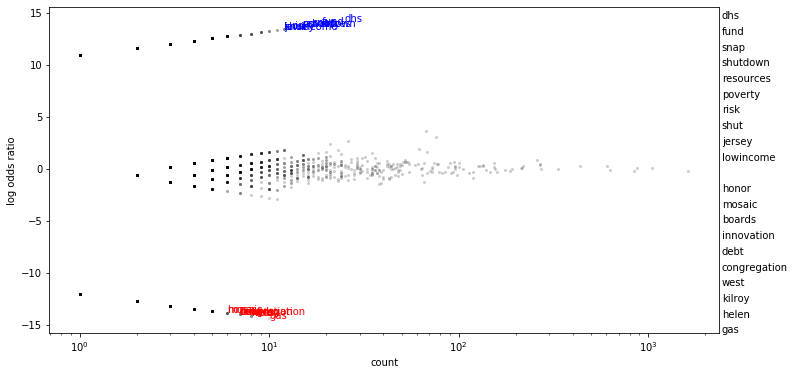

In [30]:
ax = make_word_importance_figure(log_odds_ratio, counts, ivoc, num_keywords=10)
ax.set_ylabel('log odds ratio');

The most Democrat-associated words are related to low-income policies, ex. "fund", "snap", "poverty", "lowincome".

The most Republican-associated words are related to business, ex. "gas", "debt", "innovation".

<a id="text-preprocessing"></a>
## Test different preprocessing techniques

Now let's try see this analysis changes with different text preprocessing parameters. 

The first thing we will try is preserve the case for each word. In our wrapper function, this is simply a binary parameter.

counts:
 [[12  5  2 ...  0  0  0]
 [ 8  1  0 ...  0  2  0]]
log-odds ratio:
 [ -0.1567817    1.04748389  11.64406078 ...  -0.56213059 -12.76840775
  -0.56213059]


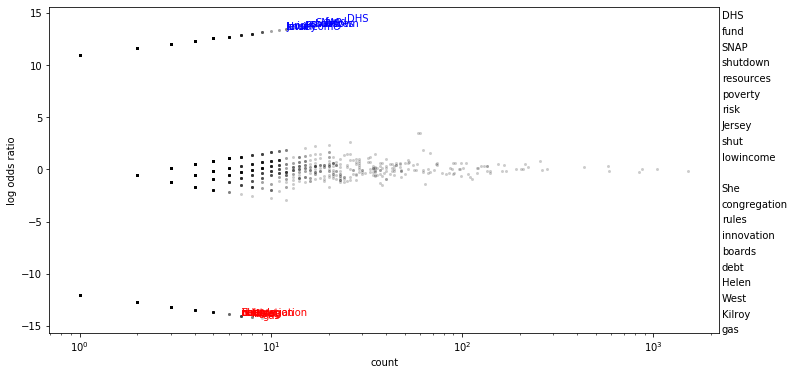

In [31]:
# include uppercase
vect, _, ivoc = text2matrix (df['speech'][:SPEECH_COUNT], max_features=MAX_FEATURES, lowercase=False, stemming=False)
aggregate_df = text_to_aggregate(df[:SPEECH_COUNT], vect)
V = len(aggregate_df['word'].unique())
counts, log_odds_ratio = get_log_odds_ratio (aggregate_df, V)
ax = make_word_importance_figure(log_odds_ratio, counts, ivoc, num_keywords=10)
ax.set_ylabel('log odds ratio');

It seems odd at first that _She_ is a top word for any party. The explanation is that representatives honored women in Women's history month. Its interesting to think why it shows up in the Republican list only. 

But you may still want to remove such words. One way is to eliminate stop words like function words (eg. _the_), pronouns (eg. _she_) etc.

counts:
 [[12  5  2 ...  0  0  0]
 [ 8  1  0 ...  0  2  0]]
log-odds ratio:
 [ -0.11512796   1.08940151  11.68589371 ...  -0.52041992 -12.7268947
  -0.52041992]


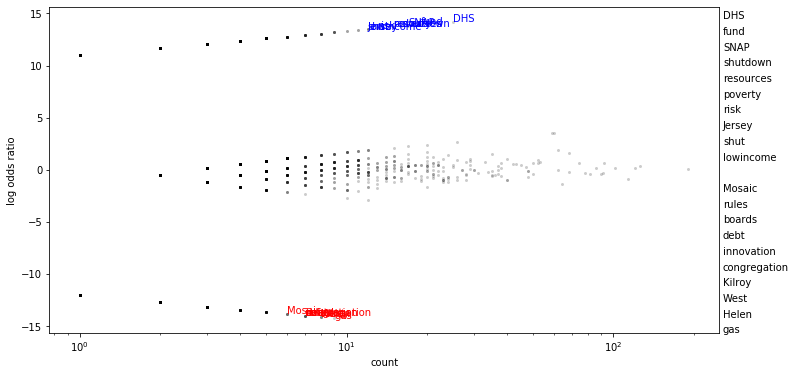

In [32]:
# remove stopwords
# stopwords from sklearn are all lowercase so we add another capitalized to it.
stop_words = set (sklearn.feature_extraction.text.ENGLISH_STOP_WORDS) | set (map(lambda x:x.capitalize(), sklearn.feature_extraction.text.ENGLISH_STOP_WORDS))
vect, _, ivoc = text2matrix (df['speech'][:SPEECH_COUNT], max_features=MAX_FEATURES, stop_words=stop_words, lowercase=False, stemming=False)
aggregate_df = text_to_aggregate(df[:SPEECH_COUNT], vect)
V = len(aggregate_df['word'].unique())
counts, log_odds_ratio = get_log_odds_ratio (aggregate_df, V)
ax = make_word_importance_figure(log_odds_ratio, counts, ivoc, num_keywords=10)
ax.set_ylabel('log odds ratio');

All these preprocessing steps aggregate counts together (ex. aggregating "she" and "She" into "she"). An extreme method of aggregation is **stemming**, which collapses word forms like `regulation` and `regulate` into one type `regul`. 

However, stemming can be very aggressive and unrelated words can collapse into one form (eg. `regular` and `regulate`). So use it with caution!!!  

In [33]:
# stem all words
vect, _, ivoc = text2matrix (df['speech'][:SPEECH_COUNT], max_features=MAX_FEATURES, lowercase=True, stemming=True)
aggregate_df = text_to_aggregate(df[:SPEECH_COUNT], vect)
V = len(aggregate_df['word'].unique())
counts, log_odds_ratio = get_log_odds_ratio (aggregate_df, V)
ax = make_word_importance_figure(log_odds_ratio, counts, ivoc, num_keywords=10)
ax.set_ylabel('log odds ratio');

NameError: name 're' is not defined

Notice that some of the "words" are actually stems that represent several words: "poverti", "congreg", "regul". However, some of the words have been inappropriately stemmed ("DHS" -> "dh"), which suggests that we might want to treat named entities as special tokens to be ignored by stemming and casing.

Conclusion: different text preprocessing steps can affect the results qualitatively. It remains a researcher's choice to best handle the data but for the next part of the notebook we just stick to the easiest pre-processing steps _i.e_ no stopword removal, no stemming and convert all words to lowercase.

## Data format

I have performed this preprocessing for all U.S. Congresses from the 98th to the 114th. The resulting data looks like this:

In [34]:
# load the aggregate file, which you should have downloaded by now
df_agg = pd.read_csv(os.path.join(basedir,'aggregate-counts.csv'),
                     usecols=['word','date','d_count','r_count'],
                     parse_dates=['date'])
vect = pickle.load(open(os.path.join(basedir,'congress-vocab.pkl'),'rb'))
ivoc = {j:i for i,j in vect.vocabulary_.items()}
print(df_agg.tail(5))

              date     word  d_count  r_count
4069995 2016-09-01  zealand        0        0
4069996 2016-09-01     zero       11        8
4069997 2016-09-01     zika      295      160
4069998 2016-09-01     zone        0        2
4069999 2016-09-01    zones        0        1


In [35]:
# get counts for the last date
counts = df_agg.loc[df_agg['date']==df_agg['date'].unique().max()][['d_count','r_count']].to_numpy().T

In [36]:
T = len(df_agg['date'].unique())
V = len(df_agg['word'].unique())
print(f'V={V} words, T={T} months')

V=10000 words, T=407 months


## Replicating "Fightin' words"

$\newcommand{\yi}{y^{(i)}}
\newcommand{\yj}{y^{(j)}}
\newcommand{\ai}{\alpha^{(i)}}
\newcommand{\aj}{\alpha^{(j)}}
\newcommand{\ni}{n^{(i)}}
\newcommand{\nj}{n^{(j)}}
$

Political scientists Monroe, Colaresi, and Quinn (MCQ 2009) present a range of techniques for identifying polarized terms and overall polarization. Here are some results from [their 2009 APSR paper](https://pdfs.semanticscholar.org/4d6c/6a8b0dbdcf055e39141f56cba8fdc59774de.pdf).

<!-- ![word polarization over time](figs/fightin-words-one-word.png =100x100) -->
<table>
<tr><td>
<img src="figs/fightin-words-one-word.png" style="width: 300px">
    </td>
    <td>
<img src="figs/fightin-words-overall.png" style="width: 300px">
    </td>
    </tr>
</table>

We will replicate these results using data from [Gentzkow et al](https://data.stanford.edu/congress_text).

<a id="polarization-metric"></a>
## Log-odds ratio as a random variable

MCQ's method treats the log-odds ratio as a function of word frequency rates, which are themselves random variables.
For each word $w$ and group $i$, we draw the frequency $\fi$ from a Dirichlet prior. The counts are then drawn from a Multinomial with $\fi$ as a parameter.

\begin{align}
\fi \sim & \text{Dirichlet}(\ai)\\
\yi \sim & \text{Multinomial}(\fi).
\end{align}

### MAP estimate of the log-odds ratio
The maximum a posteriori (MAP) estimate of $\fi_w$  is $\hat{\fi_w} = \frac{\yi_w + \ai_w}{\sum_{j} \yj_w + \aj_w},$ with the prior $\ai_w$ acting as smoothing.

Plugging in the MAP estimate $\hat{\fi_w}$ into the log-odds ratio gives, 

$$\begin{equation}
\hat{\delta}^{(i-j)}_{w} = \log \frac{\yi_{w} + \ai_{w}}{\ni + \ai_{0} - (\yi_{w} + \ai_{w})}
-
\log \frac{\yj_{w} + \aj_{w}}{\nj + \aj_{0} - (\yj_{w} + \aj_{w})},
\end{equation}$$

where $\ni = \sum_w \yi_w$ and $\ai_{0} = \sum_w \ai_{w}$.


### Variance and Z-score
It is also possible to estimate the variance of $\hat{\delta}^{(i-j)}$ and to compute a $Z$-score $\zeta^{(i-j)}_w$: 

$\begin{align}
\sigma^2(\hat{\delta}^{(i-j)}_{w}) \approx &{} \frac{1}{\yi_{w} + \ai_{w}} + \frac{1}{\yj_{w} + \aj_{w}}\\
\hat{\zeta}^{(i-j)}_{w} = &{} \hat{\delta}^{(i-j)}_{w} / \sqrt{\sigma^2(\hat{\delta}^{(i-j)}_{w})}
\end{align}$

The $Z$-score is the number of standard deviations above or below the mean. Rare words will have high variance, and consequently will tend to have lower $Z$-scores.

### Prior distribution
While it is common to use an uninformative Dirichlet prior $\alpha_w = \alpha_0$, MCQ obtain best results using an **informative** Dirichlet prior,
$\begin{equation}
\ai_{w} = \alpha_0 \frac{y_{w}}{n},
\end{equation}$
which is proportional to the overall frequency. They set $\alpha_0 = 500$. 

## Replication

Now let's try to replicate the figures from MCQ.

In [41]:
def get_log_odds_MAP(x_i, prior):
    return np.log(x_i + prior) - np.log(x_i.sum() + prior.sum() - x_i - prior)

Let's wrap these operations into a function:

In [42]:
def get_lor_stats(counts, pseudo_counts = 500, minimum_prior = 1e-3):
    G,W = counts.shape
    
    assert(G==2) # only works for two groups
    
    prior = np.array(pseudo_counts * counts.sum(0) / counts.sum())[0] + minimum_prior
    lor = get_log_odds_MAP(counts[0,], prior) - get_log_odds_MAP(counts[1,],prior)
    var_lor = 1./(counts[0,] + prior) + 1./(counts[1,] + prior)
    z_lor = lor / np.sqrt(var_lor)

    return z_lor, var_lor, lor

In [43]:
a0 = 500
z_lor, var_lor, lor = get_lor_stats(counts, pseudo_counts = a0)

## Visualizing partisan differences
Now let's make the figure again, this time using the z-scores $\hat{\zeta}$.

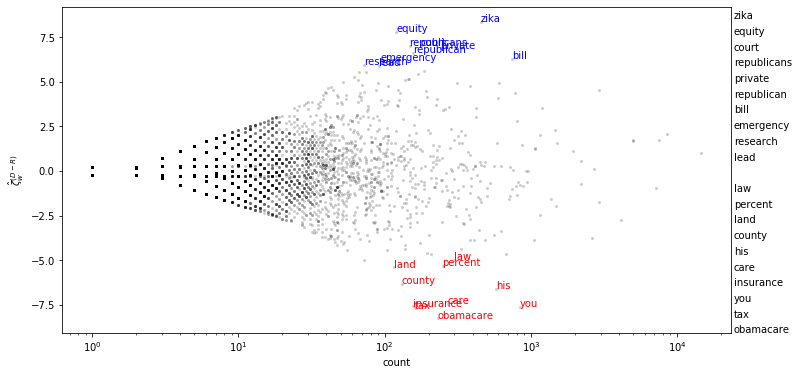

In [44]:
ax = make_word_importance_figure(z_lor, counts, ivoc, num_keywords=10)
ax.set_ylabel('$\hat{\zeta}^{(D-R)}_{w}$');

This looks better, although it now overemphasizes common words like "his" and "bill". Tuning the prior $\alpha_0$ might help. MCQ get their best results by using a Laplace prior, which is equivalent to $L_1$ regularization of the log-odds ratio. However, this requires a more complex iterative estimation procedure, which does not easily scale to temporal analysis.

## Exercise

Create the same figure as above with different values of $\alpha_0$. Try to predict what will happen if you make $\alpha_0$ larger or smaller than the value above.

## Temporal analysis

MCQ show that the term "Iraq" changes partisan valence over time. Let's see if we can replicate their conclusions.

First we need to compute $\zeta^{(d-r)}_{tw}$ for all times $t$ and words $w$.

In [44]:
dates = []
words = []
zetas = []
# for year_month in tqdm(sorted(df_agg['date'].unique())):
# counts = df_agg.loc[df_agg['date']==year_month][['d_count','r_count']].to_numpy().T
for year_month, counts_df in tqdm(df_agg.groupby('date')):
    counts = counts_df[['d_count','r_count']].to_numpy().T
    z_lor, _, _ = get_lor_stats(counts)
    for idx,word in ivoc.items():
        dates.append(year_month)
        words.append(word)
        zetas.append(z_lor[idx])
df_zeta = pd.DataFrame({'date':dates,'word':words,'zeta':zetas})

Now let's merge that back into our original data frame.

In [45]:
df_merged = pd.merge(df_agg, df_zeta, on=['word','date'])

In [46]:
df_merged.head(3)

,date,word,d_count,r_count,zeta
0,1981-01-01,00,57,5,4.553429
1,1981-01-01,000,229,139,1.751844
2,1981-01-01,10,116,119,-2.580214


Let's plot $\hat{\zeta}$ for the term "Iraq".

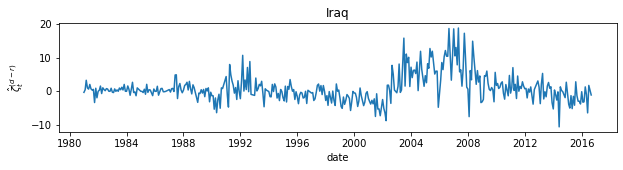

In [47]:
fig,ax = plt.subplots(1,1,figsize=timeseries_figsize)
sns.lineplot(x='date',y='zeta',data = df_merged.loc[df_merged['word']=='iraq'],ax=ax);
ax.set_ylabel('$\hat{\zeta}^{(d-r)}_t$');
ax.set_title('Iraq');

## Smoothing
Our figure matches the overall trend identified by MCQ, but their line was much smoother. They achieved this by applying an **exponentially weighted moving average** smoother to the word counts, before computing $\zeta$. Specifically, they first compute a 180-day moving average,

$\begin{equation}
m_{t,w} = \frac{1}{B} \sum_{b=0}^{B-1} x_{t-b,w},
\end{equation}$
where $B = 180$ days.

They then compute an exponentially weighted filter over these moving averages,

$\begin{equation}
\hat{x}_{t,w} = \alpha x_{t,w} + (1 - \alpha) \hat{x}_{t-1,w}.
\end{equation}$

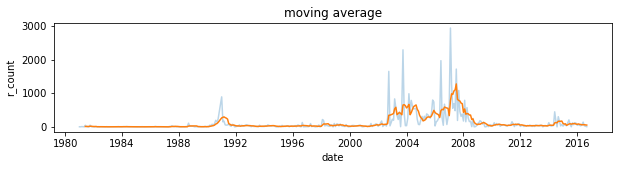

In [48]:
fig,ax = plt.subplots(1,1,figsize=timeseries_figsize)
# original counts
s = df_merged.loc[df_merged['word']=='iraq','r_count']
ax = sns.lineplot(y=s, x=df_merged.loc[df_merged['word']=='iraq','date'], alpha=0.3,ax=ax)
# 6-month moving average
m = s.rolling(6).mean() # rolling average over six month window
sns.lineplot(y=m, x=df_merged.loc[df_merged['word']=='iraq','date'],ax = ax)
plt.title('moving average');

### Choosing the filter decay

MCQ specify that $\alpha = 0.01$, but that's per day. 

We have to convert to per-month, while preserving the same "half-life."


In [49]:
alpha_per_day = 0.01
alpha_per_month = 1 - np.exp(np.log(1 - alpha_per_day) * 30)

In [50]:
print(f'alpha per month = {alpha_per_month:.3f}')
print(f'decay after six months = {(1-alpha_per_month)**6}')
print(f'decay after 180 days   = {(1-alpha_per_day)**180}')

alpha per month = 0.260
decay after six months = 0.1638079697080874
decay after 180 days   = 0.16380796970808742


## Plot with smoothing

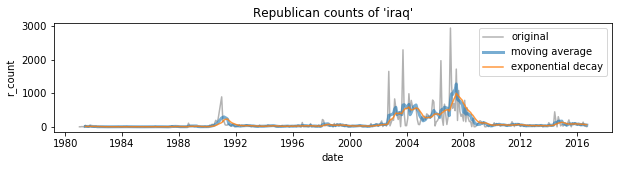

In [51]:
# original counts
s = df_merged.loc[df_merged['word']=='iraq','r_count']
x_series = df_merged.loc[df_merged['word']=='iraq','date']
fig,ax = plt.subplots(1,1,figsize=timeseries_figsize)
ax = sns.lineplot(y=s, x=x_series, alpha=0.3,color='k')

# 6-month moving average
m = s.rolling(6).mean() # rolling average over six month window
ax = sns.lineplot(y=m, x=x_series,linewidth=3, alpha=0.6)

m_ewm = m.ewm(alpha=alpha_per_month).mean()

ax = sns.lineplot(y=m_ewm, x=x_series,alpha=0.8)
ax.set_title('Republican counts of \'iraq\'')
ax.legend(['original','moving average','exponential decay']);

## Filtering all the words

Now we'll apply this filter to all counts in the data. This takes roughly 20-30 minutes on my laptop, so you can just load in the counts.

In [52]:
recomputing_all_data_files = False
if recomputing_all_data_files:
    words = []
    dates = []
    filtered_counts = {'d_count':[],
                       'r_count':[]}
    for word in tqdm(df_agg['word'].unique()):
        df_word = df_merged.loc[df_merged['word']==word]
        words.extend(df_word['word'])
        dates.extend(df_word['date'])
        for count_group in ['d_count','r_count']:
            s = df_word[count_group]
            filtered = s.rolling(6).mean().ewm(alpha=alpha_per_month).mean()
            filtered_counts[count_group].extend(filtered)
    df_filtered = pd.DataFrame({'d_count':filtered_counts['d_count'],
                                'r_count':filtered_counts['r_count'],
                                'word':words,
                                'date':dates}).dropna()
    df_filtered.to_csv('aggregate-counts-smoothed.csv')
else:
    df_filtered = pd.read_csv(os.path.join(basedir,'aggregate-counts-smoothed.csv'), 
                              parse_dates=['date'],
                              usecols=['d_count','r_count','word','date'])

In [53]:
df_filtered.head(3)

,d_count,r_count,word,date
0,17.166667,13.333333,00,1981-06-01
1,12.759778,16.207391,00,1981-07-01
2,10.532655,15.970943,00,1981-08-01


### Zeta from smoothed counts

Now we will apply the same log-odds ratio computation from above, but use smoothed counts. For speed I have pre-computed all the smoothing.

In [54]:
if recomputing_all_data_files:     # takes roughly 1 minute on my laptop
    dates = []
    words = []
    zetas = []
    # TODO: replace with pandas.DataFrame.groupby
    for year_month in tqdm(sorted(df_filtered['date'].unique())):
        counts = df_filtered.loc[df_filtered['date']==year_month][['d_count','r_count']].to_numpy().T
        z_lor, _, _ = get_lor_stats(counts)
        for idx,word in ivoc.items():
            #df_agg.loc[(df_agg['word']==word) & (df_agg['date']==year_month),'zeta'] = z_lor[idx]
            dates.append(year_month)
            words.append(word)
            zetas.append(z_lor[idx])
    df_zeta_filt = pd.DataFrame({'date':dates,'word':words,'zeta':zetas})
    df_zeta_filt.to_csv('zeta-filtered.csv')
else:
    df_zeta_filt = pd.read_csv(os.path.join(basedir,'zeta-filtered.csv'), 
                               parse_dates=['date'],
                               usecols=['zeta','word','date'])

In [55]:
df_zeta_filt.head(3)

,date,word,zeta
0,1981-06-01,mr,-1.053863
1,1981-06-01,president,-3.574481
2,1981-06-01,am,-1.268734


<a id="replicate-figure"></a>
## Zeta over smoothed counts
Now that we have the filtered zeta scores, we can replicate the original "iraq" figure.

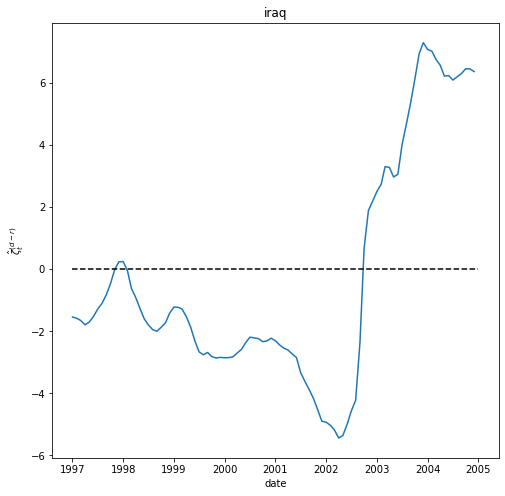

In [63]:
starPILdate = datetime.strptime('01-01-97', '%d-%m-%y')
end_date = datetime.strptime('31-12-2004', '%d-%m-%Y')
df_zeta_filt_ex = df_zeta_filt[(df_zeta_filt.loc[:, 'date'] >= start_date) &
                               (df_zeta_filt.loc[:, 'date'] <= end_date)]
fig,ax = plt.subplots(1,1,figsize=[8, 8])
ax = sns.lineplot(x='date',y='zeta',data = df_zeta_filt_ex.loc[df_zeta_filt_ex['word']=='iraq'],ax=ax)
ax.set_title('iraq')
ax.set_ylabel('$\hat{\zeta}^{(d-r)}_t$');
ax.plot([start_date, end_date], [0, 0], c='k', linestyle='--')
plt.show()

<style>
.center {
  display: block;
  margin-left: auto;
  margin-right: auto;
  width: 100%;
}
</style>

<img src="figs/fightin-words-one-word.png" class="center">

This looks pretty good! Let's try a few other words that are likely to be highly partisan.

<a id="per-word-polarization"></a>
## Investigating examples of per-word polarization

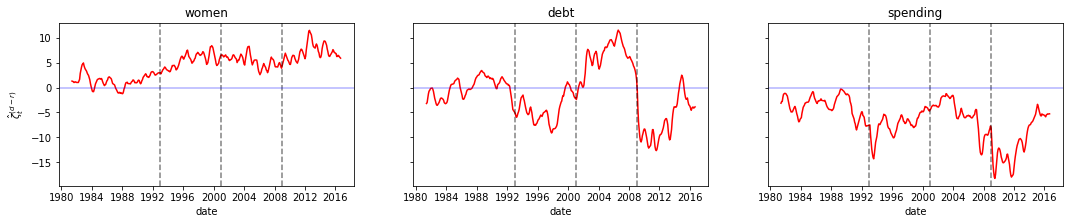

In [74]:
_, axes = plt.subplots(1,3,sharey=True,figsize=[18, 3])
words = ['women','debt','spending']
for word, ax in zip(words, axes):
    sns.lineplot(x='date',y='zeta',data= df_zeta_filt.loc[df_zeta_filt['word']==word], ax = ax, color='r')
    ax.set_title(word)
    ax.axvline(datetime(year=1993,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Clinton (D) presidency
    ax.axvline(datetime(year=2001,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Bush II (R)
    ax.axvline(datetime(year=2009,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Obama (D)
    ax.axhline(0,color='b',linestyle='-', alpha=0.3)
    ax.set_ylabel('$\hat{\zeta}^{(d-r)}_t$');

- The term "women" is generally associated with Democrats, especially after 2000. 
- The term "debt" is preferred by out-of-power parties.
- The term "spending" is associated with Republicans, especially during the early part of the Obama presidency (2009).

### Detecting words that grow/decline in partisanship
We can systematically detect the most consistently polarized words using statistics.

We will use the Spearman correlation coefficient to detect *monotonic* growth and decline:

$$\rho(X,Y) = \frac{cov(R_{X}, R_{Y})}{\sigma(R_{X}) \sigma(R_{Y})}$$

where $R_{x}$ equals the ranked position of $x$ in the data $X$.

Unlike other metrics such as Pearson's correlation coefficient, Spearman's correlation makes no assumption about the data and can therefore capture a variety of growth patterns (linear, exponential, etc.). 

The Spearman correlation coefficient has some limitations: ex. it treats sharp increases or decreases the same as small increases/decreases, which would be penalized with other correlations (ex. Pearson).
However, we use it to make an initial exploration of the most obvious increase/decrease trends in word partisanship.

Let's compute the Spearman correlation between the dates and the zeta values for all words, and then sort the series by their correlation.

In [75]:
def compute_correlation(data):
    # convert date to timestamps
    data.loc[:, 'date'] = data.loc[:, 'date'].apply(lambda x: x.timestamp())
    # returns correlation, p-value
    correl_data = spearmanr(data.loc[:, 'date'].values, data.loc[:, 'zeta'].values)
    correl_data = pd.Series(correl_data, index=['correl', 'pval'])
    return correl_data
df_zeta_filt_correls = df_zeta_filt.groupby('word').apply(lambda x: compute_correlation(x))
# add word column
df_zeta_filt_correls = df_zeta_filt_correls.reset_index()
display(df_zeta_filt_correls.head())

,word,correl,pval
0,00,0.119760,1.629025e-02
1,000,0.316824,7.992809e-11
2,10,-0.152216,2.211334e-03
3,100,-0.443467,8.493035e-21
4,100th,0.225695,4.872926e-06


Let's sort the words and look at the words with the highest and lowest correlations.

In [76]:
## plot top-k 
def plot_top_k_words(data, data_correls, top_k=10):    
    rows = 3
    cols = 4
    width = 4
    height = 3
    f, axs = plt.subplots(rows, cols, figsize=(cols * width, rows * height))
    for i in range(top_k):
        # get i^th word and correlation value
        data_correl_i = data_correls.iloc[i, :]
        word_i = data_correl_i.loc['word']
        correl_i = data_correl_i.loc['correl']
        # get dates, zeta scores
        data_i = data[data.loc[:, 'word']==word_i]
        # plot
        row = int(i / cols)
        col = i % cols
        ax = axs[row, col]
        ax.plot(data_i.loc[:, 'date'], data_i.loc[:, 'zeta'], c='b', linestyle='-')
        # put word and correlation in title
        ax.set_title('%s (r=%.3f)'%(word_i, correl_i))
        # add 0 horizontal line
        ax.plot(data_i.loc[:, 'date'], [0,]*len(data_i.loc[:, 'date']), c='k', linestyle='--')
    # delete empty plots
    for i in range(top_k, rows*cols):
        row = int(i / cols)
        col = i % cols
        f.delaxes(axs[row, col])
    # squish plots together
    plt.tight_layout()
    plt.show()

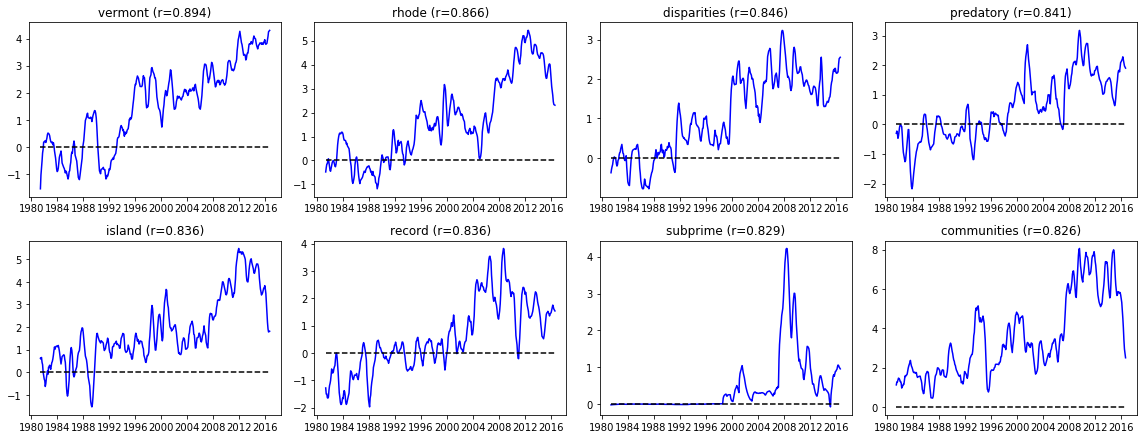

In [77]:
top_k = 8
# sort from high to low
df_zeta_filt_correls.sort_values('correl', inplace=True, ascending=False)
plot_top_k_words(df_zeta_filt, df_zeta_filt_correls, top_k=top_k)

Some noteworthy trends:

- "Rhode Island" became more Democrat-aligned, due to more Rhode Island outsized presence on committees and in positions of power (ex. [Jack Reed](https://en.wikipedia.org/wiki/Jack_Reed_(Rhode_Island_politician)) on committees, [James Langevin](https://en.wikipedia.org/wiki/James_Langevin) as speaker pro tempore, [Lincoln Chafee](https://en.wikipedia.org/wiki/Lincoln_Chafee) and [John Chafee](https://en.wikipedia.org/wiki/John_Chafee) as left-leaning Republicans).
- "predatory" and "subprime" became more Democrat-aligned, likely due to criticism of banks' [predatory lending](https://en.wikipedia.org/wiki/Predatory_lending) practices with respect to loans and mortgages ("illegal **predatory** lending schemes", "losses from the **subprime** mortgage market").
- "disparities" became more Democrat-aligned, likely due to the increased interest in health care that led to Obamacare (ex. "**disparities** in health care").

Now let's look at the most consistently decreasing words. Remember that these words are also highly polarized but in the opposite direction (toward Republicans).

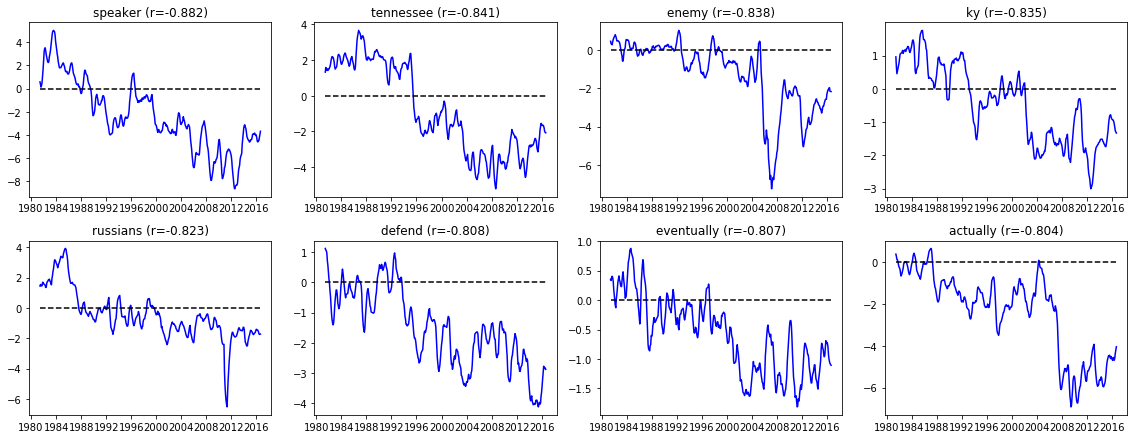

In [78]:
top_k = 8
# sort from low to high
df_zeta_filt_correls.sort_values('correl', inplace=True, ascending=True)
plot_top_k_words(df_zeta_filt, df_zeta_filt_correls, top_k=top_k)

Some noteworthy trends:

- "Tennessee", "KY" became more Republican-aligned, due to elections of more Republican representatives from those states (see [TN](https://en.wikipedia.org/wiki/United_States_congressional_delegations_from_Tennessee), [KY](https://en.wikipedia.org/wiki/United_States_congressional_delegations_from_Kentucky)), especially [Hal Rogers](https://en.wikipedia.org/wiki/Hal_Rogers) from KY. Al Gore was TN Senator until 1993, which marked a turning point toward more Republican house members.
- "defend" and "enemy" became more Republican-aligned, likely due to violence in the Middle East ("if the U.S.A. will not **defend** its ally [Israel]", "our mutual **enemy**, Iran"), especially in the wake of the Gulf War and 9/11.
- "eventually", "actually" became more Republican-aligned, often used as criticism toward administration ("will **eventually** pay even more taxes", "Democrats continue to filibuster our efforts to **actually** get on the bill").

We have used a correlation metric to explore some consistent trends in polarization. It is important to note that some of the trends are difficult to explain (ex. "speaker") and should be taken with a grain of salt. 

<a id="aggregate-polarization"></a>
## Aggregate partisanship

MCQ measure overall partisanship at time $t$ by the variance of $\zeta_{tw}$ across words $w$. 

\begin{align}
\overline{\zeta}_t = &{} \frac{1}{V} \sum_{w=1}^V \hat{\zeta}_{tw}\\
V[\hat{\zeta}_t] = &{} \frac{1}{V} \sum_{w=1}^V (\hat{\zeta}_{tw} - \overline{\zeta}_t)^2
\end{align}

This is easy to compute in Pandas, using the `groupby` command:

In [84]:
var_zeta = df_zeta_filt.groupby(['date']).var()['zeta']
print(var_zeta.head(3))

date
1981-06-01    0.681973
1981-07-01    0.698495
1981-08-01    0.699963
Name: zeta, dtype: float64


Now we're ready to plot the aggregate partisanship.

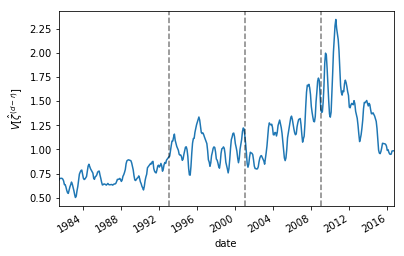

In [85]:
ax = plt.subplot()
var_zeta.plot(ax = ax)
ax.axvline(datetime(year=1993,month=1,day=1),linestyle='--',color='k',alpha=0.5)
ax.axvline(datetime(year=2001,month=1,day=1),linestyle='--',color='k',alpha=0.5)
ax.axvline(datetime(year=2009,month=1,day=1),linestyle='--',color='k',alpha=0.5)
ax.set_ylabel('$V[\hat{\zeta}^{(d-r)}]$');

This is consistent with an increase, particulary in the period at the end of Bush's second term and the beginning of Obama's first term (2007-2011). This coincided with the global financial crisis and associated stimulus and recovery programs, as well as the passage of the Affordable Care Act ("Obamacare").

# Some simple baselines

We can compute several baselines from the (smoothed) frequencies $\fi_w$. One approach is to take norms of the difference between the frequency distributions:

\begin{align}
L_1 = &{} \sum_w |\fi_w - \fj_w|\\
L_2 = &{} \sqrt{\sum_w (\fi_w - \fj_w)^2}.
\end{align}

## Information theory baselines

A slightly more complex baseline is the Jensen-Shannon (JS) divergence, which in turn is based on the Kullback-Leibler (KL) divergence:

\begin{align}
D_{KL}(p, q) = &{} \sum_t p_t \log \frac{p_t}{q_t}\\
JS(\fi, \fj) = &{} \frac{1}{2} D_{KL}(\fi, \overline{f}) + \frac{1}{2} D_{KL}(\fj, \overline{f}),\\
\overline{f} = &{} \frac{1}{2}(\fi + \fj).
\end{align}

The JS divergence is closely related to the log-odds ratio, but does not make use of a prior on the word frequencies.

In [86]:
# distance metrics
l2_norm = lambda t1, t2: np.sqrt(((t1 - t2)**2).sum())
l1_norm = lambda t1, t2: np.abs(t1-t2).sum()
kl_div = lambda t1, t2: t1.dot(np.log(t1) - np.log(t2))
js_div = lambda t1, t2: .5 * (kl_div(t1, .5 * (t1 + t2)) + kl_div(t2, .5 * (t1 + t2)))

In [87]:
smoother = .5 # simple Laplace smoothing

def counts_to_probs(counts):
    assert(len(counts.shape)==1)
    
    probs = counts + smoother
    return probs / probs.sum()

def compute_dists(distance, df):
    dates = []
    dists = []
    for date,local_stats in df.groupby('date'):
        d_vec = counts_to_probs(local_stats['d_count'].to_numpy())
        r_vec = counts_to_probs(local_stats['r_count'].to_numpy())
        
        dists.append(distance(d_vec, r_vec))
        dates.append(date)
    
    df_out = pd.DataFrame({'date':dates, 'distance': dists})

    # apply exponentially weighted smoothing to the output
    df_out['dist_smoothed'] = df_out['distance'].rolling(6).mean().ewm(alpha=alpha_per_month).mean()
    return df_out

## Plotting baseline measures

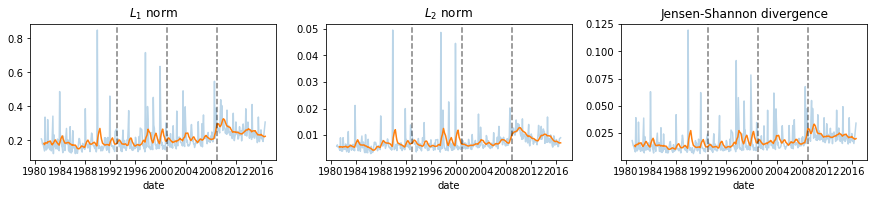

In [88]:
_,axes = plt.subplots(1,3,figsize=[15,2.5])
for ax, dist, title in zip(axes, [l1_norm, l2_norm, js_div], 
                           ['$L_1$ norm', '$L_2$ norm', 'Jensen-Shannon divergence']):
    df_dist = compute_dists(dist, df_agg)
    sns.lineplot(x='date',y='distance',data=df_dist,ax=ax, alpha =0.3);
    sns.lineplot(x='date',y='dist_smoothed',data=df_dist,ax=ax);
    ax.set_title(title)

    ax.axvline(datetime(year=1993,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Clinton (D) presidency
    ax.axvline(datetime(year=2001,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Bush II (R)
    ax.axvline(datetime(year=2009,month=1,day=1),linestyle='--',color='k',alpha=0.5) # beginning of Obama (D)
    ax.set_ylabel('');

To be fair, these figures might look better if the methods were applied to the temporally-smoothed counts rather than using simple Laplace smoothing. Nonetheless, the $L_1$ norm and Jensen-Shannon divergence also suggest an increase in partisanship in the beginning of Obama's first term.

# Extensions

- Re: correlation analysis, besides growth and decline, what other trends should we model in partisanship? Ex. a seasonal trend might capture regular fluctuations based on elections, world trends.
- How can we extend the idea of correlation to find groups of words that change in tandem? Ex. state names that trend Republican at the same time => groups of states with similar voting records.
- Can you come up with groups of words that are semantically similar, to compare their relative time series? Ex. all finance-based words.
- MCQ argue that an informative Dirichlet prior gives better estimates of the log-odds ratio than the symmetric prior that is typically used, e.g., in topic modeling work. Recompute the results above using a symmetric prior and see if they are significantly changed.
- Examine the impact of temporal smoothing on the overall partisanship trends. Do other smoothers give different results?
- The aggregate partisanship figure in the previous section seems to have some "high frequency" component that varies throughout the year. Try to identify and explain this component.
- Use multiple regression to test the impact of exogeneous political factors such as the timing of elections and split party control of the legislature and presidency.